In [1]:
#TASK 1:Setup and Basic Extraction
!pip install ffmpeg-python


In [20]:
import ffmpeg
import ffmpeg
import matplotlib.pyplot as plt
import re

In [21]:
#TASK 1:Setup and Basic Extraction
def extract_frame_info(video_path):
    probe = ffmpeg.probe(video_path)
    video_stream = next((stream for stream in probe['streams'] if stream['codec_type'] == 'video'),)
    video_info = {
        'width': video_stream['width'],
        'height': video_stream['height'],
        'r_frame_rate': video_stream['r_frame_rate'],
        'nb_frames': video_stream['nb_frames'],
        'duration': float(probe['format']['duration'])
    }
    return video_info

video_path = '/content/ocean.mp4'
frame_info = extract_frame_info(video_path)
print(frame_info)

{'width': 1280, 'height': 720, 'r_frame_rate': '24000/1001', 'nb_frames': '677', 'duration': 28.237}


In [22]:
#TASK 2:Frame Type Analysis
def count_frame_types(video_path):
    result = ffmpeg.probe(video_path, select_streams='v', show_frames=None, show_entries='frame=pict_type')
    frames = result['frames']
    frame_counts = {'I': 0, 'P': 0, 'B': 0}
    for frame in frames:
      frame_type = frame['pict_type']
      frame_counts[frame_type] += 1
    return frame_counts

frame_counts = count_frame_types(video_path)
total_frames = sum(frame_counts.values())
percentages = {frame: count / total_frames * 100 for frame, count in frame_counts.items()}
print(f"Frame counts: {frame_counts}")
print(f"Percentages: {percentages}")


Frame counts: {'I': 3, 'P': 175, 'B': 499}
Percentages: {'I': 0.4431314623338257, 'P': 25.849335302806498, 'B': 73.70753323485968}


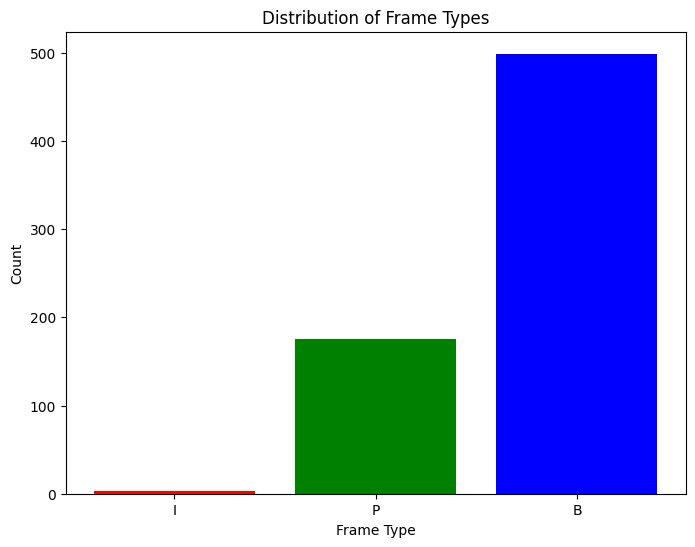

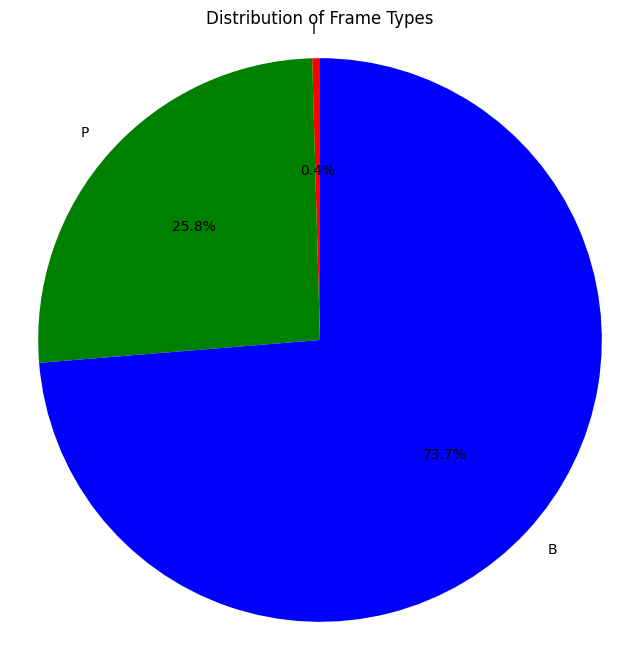

In [23]:
# TASK 2:Plotting the distribution of frame types
frame_types = list(frame_counts.keys())
counts = list(frame_counts.values())

# Bar graph
plt.figure(figsize=(8, 6))
plt.bar(frame_types, counts, color=['red', 'green', 'blue'])
plt.xlabel('Frame Type')
plt.ylabel('Count')
plt.title('Distribution of Frame Types')
plt.show()

# Pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=frame_types, autopct='%1.1f%%', startangle=90, colors=['red', 'green', 'blue'])
plt.title('Distribution of Frame Types')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


In [29]:
# TASK 3: Extracting and Displaying Frames
from PIL import Image
import cv2

def extract_frames(video_path, frame_type):
    output_path = f'/content/{frame_type}_frames'
    !mkdir -p $output_path
    (
        ffmpeg
        .input(video_path)
        .filter('select', f"eq(pict_type,{frame_type})")
        .output(f'{output_path}/{frame_type}_%03d.jpg')
        .overwrite_output()
        .run(quiet=True)
    )

def display_frames(frame_type, num_frames=5):
    frame_dir = f'/content/{frame_type}_frames'
    for i in range(1, num_frames + 1):
        frame_path = f'{frame_dir}/{frame_type}_{i:03d}.jpg'
        try:
            img = Image.open(frame_path)
            img.show()
        except FileNotFoundError:
            print(f"Frame {frame_path} not found.")

# Extract and display I, P, and B frames
extract_frames(video_path, 'I')
display_frames('I', num_frames=3)

extract_frames(video_path, 'P')
display_frames('P', num_frames=3)

extract_frames(video_path, 'B')
display_frames('B', num_frames=3)

In [27]:
import ffmpeg
import ffmpeg
import matplotlib.pyplot as plt
import re
from PIL import Image
import cv2
import os


# TASK 4: Frame Size Analysis and Compression Efficiency

def calculate_frame_sizes(frame_type):
    """Calculates the file sizes of extracted frames."""
    frame_dir = f'/content/{frame_type}_frames'
    total_size = 0
    num_frames = 0
    for filename in os.listdir(frame_dir):
        filepath = os.path.join(frame_dir, filename)
        total_size += os.path.getsize(filepath)
        num_frames += 1
    return total_size, num_frames

# Calculate sizes for each frame type
i_size, i_count = calculate_frame_sizes('I')
p_size, p_count = calculate_frame_sizes('P')
b_size, b_count = calculate_frame_sizes('B')

# Calculate average sizes
avg_i_size = i_size / i_count if i_count > 0 else 0
avg_p_size = p_size / p_count if p_count > 0 else 0
avg_b_size = b_size / b_count if b_count > 0 else 0

print(f"Average I frame size: {avg_i_size:.2f} bytes")
print(f"Average P frame size: {avg_p_size:.2f} bytes")
print(f"Average B frame size: {avg_b_size:.2f} bytes")

# Discussion on Compression Efficiency
print("\nCompression Efficiency:")
print("I frames (intra-coded) are larger because they contain all the necessary information for decoding.")
print("P frames (predictive-coded) use motion estimation and compensation to refer to previous I or P frames, resulting in smaller sizes.")
print("B frames (bidirectional-coded) use both forward and backward references, leading to the smallest sizes by exploiting temporal redundancy.")



Average I frame size: 48514.05 bytes
Average P frame size: 47881.72 bytes
Average B frame size: 47375.03 bytes

Compression Efficiency:
I frames (intra-coded) are larger because they contain all the necessary information for decoding.
P frames (predictive-coded) use motion estimation and compensation to refer to previous I or P frames, resulting in smaller sizes.
B frames (bidirectional-coded) use both forward and backward references, leading to the smallest sizes by exploiting temporal redundancy.


In [31]:
# Task 5: Reconstructing Video from I Frames

def reconstruct_video(frame_dir, output_path, frame_rate=24):
    """Reconstructs a video from extracted I frames."""
    input_pattern = f'{frame_dir}/I_%03d.jpg'
    try:
        out, err = (
            ffmpeg
            .input(input_pattern, pattern_type='glob', framerate=frame_rate)
            .output(output_path, vcodec='libx264', pix_fmt='yuv420p')
            .overwrite_output()
            .run(capture_stdout=True, capture_stderr=True)
        )
    except ffmpeg.Error as e:
        print(f"Error: {e}")
        print(f"FFmpeg Output:\n{e.stdout.decode()}")
        print(f"FFmpeg Error Output:\n{e.stderr.decode()}")
        return

    print(f"Reconstructed video saved as: {output_path}")


# Reconstruct video from I frames
i_frame_dir = '/content/I_frames'
output_video_path = '/content/reconstructed_i_video.mp4'
reconstruct_video(i_frame_dir, output_video_path, frame_rate=10)  # Adjust frame rate as needed

print(f"Reconstructed video saved as: {output_video_path}")

Error: ffmpeg error (see stderr output for detail)
FFmpeg Output:

FFmpeg Error Output:
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-lib